In [10]:
%%time
print("start")
%run -i 'myimports.py'
%run -i 'nlp_processing.py'

def coordinates(title):
    return [40, 220, 150, 300, 183, 494] #first last pages, x coord and width, y coord and height

def create_txt(title):
    if not os.path.isfile(title+".txt"):
        if os.path.isfile(title+".pdf"):
            c = coordinates(title+".pdf")
            convert = "pdftotext -f %d -l %d -x %d -W %d -y %d -H %d %s.pdf" %(c[0],c[1],c[2],c[3],c[4],c[5],title)
            process = subprocess.Popen(convert.split(), stdout=subprocess.PIPE)
            output, error = process.communicate()

contents = ["Introduction",
            "The Negro and Language",
            "The Woman of Color and the White Man",
            "The Man of Color and the White Woman",
            "The So-Called Dependency Complex of Colonized Peoples",
            "The Fact of Blackness",
            "The Negro and Psychopathology",
            "The Negro and Recognition",
            "By Way of Conclusion"]
contents = [x.upper() for x in contents]
the_regex = "r"+("\s|".join(re.escape(s) for s in contents))

start
CPU times: user 7.9 s, sys: 1.07 s, total: 8.97 s
Wall time: 8.98 s


In [11]:
full_text = ""
with open("black.txt", "r") as r:
#     full_text = r.read().replace("INTRODUCTION", "").replace("\n"," ").replace(". . . ", "")
    lines = r.readlines()
    for line in lines:
        full_text +=line.replace("\n", " ")
full_text = full_text.replace("INTRODUCTION", "").replace(". . . ", "")
full_text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', full_text)
with open("test.txt", "w+") as w:
    w.write(full_text)

In [12]:
for i in contents:
    if i in full_text:
        print(i, full_text.find(i))

THE NEGRO AND LANGUAGE 12317
THE WOMAN OF COLOR AND THE WHITE MAN 54075
THE MAN OF COLOR AND THE WHITE WOMAN 92283
THE SO-CALLED DEPENDENCY COMPLEX OF COLONIZED PEOPLES 124054
THE FACT OF BLACKNESS 170251
THE NEGRO AND PSYCHOPATHOLOGY 223008
THE NEGRO AND RECOGNITION 348417
BY WAY OF CONCLUSION 369824


In [13]:
text_split = re.split(the_regex, full_text)

In [14]:
for ind, i in enumerate(text_split):
    with open("chapters/"+str(ind)+"_"+contents[ind].replace(" ", "_")+".txt", "w+") as f:
        f.write(i)

In [15]:
only_files = []
for file in listdir("chapters"):
    if file.endswith(".txt"):
        only_files.append([open("chapters/"+file).read(), file])
#         only_files.append(open("chapters/"+file).read())



In [19]:
podcast_name = "chapters"
# os.listdir(podcast_name)
onlyfiles = folder_to_filelist(podcast_name)
# print(onlyfiles[0]) #works

doc_bin = DocBin(store_user_data=True) #docbin container for serialization
docs = [] #list of docs 
print("starting")
for doc, name in nlp.pipe(onlyfiles, as_tuples=True): #piping all collection of docs to make doclist and docbin
    #each doc contians hostname, guest, title, entities mentioned, and summary
    name = re.split("[.\|]",name)[:-1]
    name=name[1:] if name[0][1:].isdigit() else name # store name of guest and topic, add to doc user data
    
#     doc.user_data["host"] = podcast_host
#     doc.user_data["guest"]= str(name[0]).replace("_"," ")
    doc.user_data["title"]= str(name)
    doc.user_data["entis"] = [(ent.text, ent.label_) for ent in doc.ents]
    doc = keep_ents(doc) #extract and save all entities by filtering entity extraction
    docs.append(doc)
    doc_bin.add(doc) #add doc to list and bin
print("done")    
with open("cucumber/book_doc.bin", "wb") as f: #write bytestream to first_doc.bin
    f.write(doc_bin.to_bytes())

starting


/ilab/users/hs884/.local/lib/python3.8/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /ilab/users/hs884/.local/lib/python3.8/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


done


In [25]:
for d in docs:
    d.user_data["guest"] = "fanon"
for d in docs:
    print(d.user_data["books"])

['Pigalle', 'Marseille', 'New York', 'Antilles', 'Antilles', 'the Negro of Africa']
['Paris', 'Paris', 'Paris', 'Paris', 'Martinique', 'Marigot', 'Gros-Morne', 'Paris', 'Gallimard', 'France', 'France', 'France', 'Le Havre', 'Marseille', 'Antilles', 'Martinique', 'France', 'ed.', 'Paris', 'Universitaires de France', 'Antilles', 'France', 'Martinique', 'France', 'Martinique', 'Europe', 'France', 'Paris', 'Prsence Africaine', 'the United States', 'France', 'France', 'France', 'Tabernacle', 'France', 'France', 'Panissires', 'France', 'Paris', 'Marseille', 'Pigalle', 'France', 'Savannah', 'Savannah', 'Savannah', 'France', 'Antilles', 'Congo', 'Antilles', 'the Antilles Negro', 'France', 'Martinique', 'the Antilles Negro', 'Orphe Noir', 'Antilles', 'Martinique-Guadeloupe-Haiti', 'Senegal', 'Antilles', 'Antilles', 'Brittany', 'Antilles', 'Nairobi', 'the Kingdom of Heaven', 'London', 'Lyon', 'France', 'Savannah', 'Savannah', 'Rouen', 'Strasbourg', 'Africa', 'Dakar', 'Rufisque', 'Negro', 'France

In [27]:
att_to_csv(docs, "books")

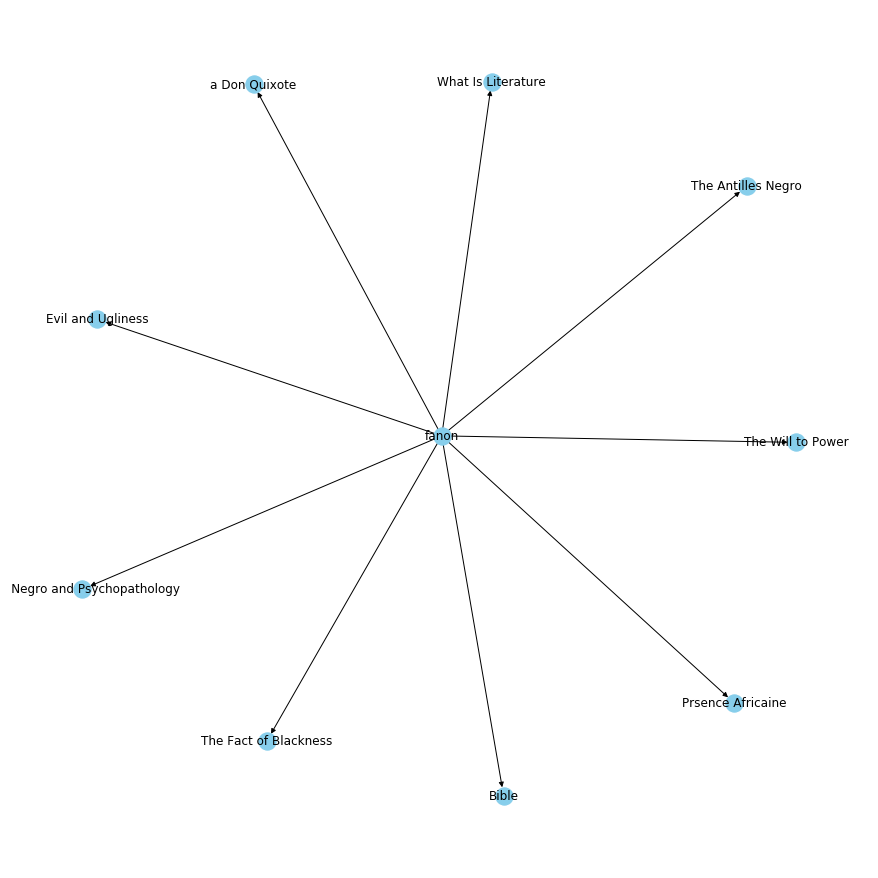

In [28]:
#generate megagraph for book ents
edges = pd.read_csv("booksEdges.csv", sep=',').drop("id", axis=1).values.tolist()
nodes = pd.read_csv('booksNodes.csv',sep=',').set_index("id").to_dict("index")

source = [nodes.get(e[0])["name"] for e in edges]
target = [nodes.get(e[1])["name"] for e in edges]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':np.ones(len(source))})
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#following are other example graphviews

In [35]:
document_size = 2700
topic_size = 1700
filter_size=16



In [55]:
full_doc = nlp(open("black.txt").read().replace("\n"," "))

In [56]:
sents = [sent.text for sent in full_doc.sents]

In [57]:
%run -i 'timestamp_generation.py'
dictionary, model = generate_model("black.txt", document_size, topic_size)
one_topic_confi = load_confidences("black.txt", topic_size, dictionary, model, sents, basic_completion) #generate initial topics + confidences, then smooth by filling in empty values and averaging


algo_stamps = get_algo_timestamps(one_topic_confi, 40) #algo generated timestamps
# actual_stamps = get_real_timestamps(soup, sents, timesfolder, file) #description generated timestamps



In [58]:
for stamp in algo_stamps:
    print(stamp)

[ 0 23]
[111  23]
[259  18]
[354   3]
[537  23]
[725   3]
[816   3]
[992   3]
[1086   13]
[1178   18]
[1294   13]
[1439   19]
[1543   30]
[1707   29]
[1917   18]
[2067   18]
[2130   15]
[2328   20]
[2618   18]
[2734    5]
[2787    5]
[2960   23]
[3052   23]
[3103    3]
[3204    3]
[3270    8]
[3383    8]
[3438   18]
[3664    3]
[3809   28]
[3873   28]
[3958   19]
[4043   11]
[4265   30]


In [59]:
%%time
stamped_docs = []
i = 0
while i < len(algo_stamps)-1:
    stamped_docs.append(nlp(" ".join(sents[algo_stamps[i][0]:algo_stamps[i+1][0]])))
    i+=1
stamped_docs.append(nlp(" ".join(sents[algo_stamps[-1][0]:])))    
    
# for stamp in algo_stamps:
#     stamped_docs.append(nlp(" ".join(sents[stamp[0]:stamp[1]])))

CPU times: user 8.72 s, sys: 80.7 ms, total: 8.8 s
Wall time: 8.8 s


In [65]:
%%time
actual_stamps = []
for ind, sent in enumerate(sents):
    for chap in contents:
        if chap in sent:
            print(chap, ind)
            actual_stamps.append(ind)

INTRODUCTION 0
THE NEGRO AND LANGUAGE 167
THE WOMAN OF COLOR AND THE WHITE MAN 582
THE MAN OF COLOR AND THE WHITE WOMAN 1015
THE SO-CALLED DEPENDENCY COMPLEX OF COLONIZED PEOPLES 1445
THE FACT OF BLACKNESS 1911
THE NEGRO AND PSYCHOPATHOLOGY 2631
BY WAY OF CONCLUSION 4236
CPU times: user 5.71 ms, sys: 127 µs, total: 5.84 ms
Wall time: 5.62 ms


In [60]:
for ind, doc in enumerate(stamped_docs):
    print(ind, doc.user_data["summary"],"\n")

0 ['The black is a black man; that is, as the result of a series of aberrations of affect, he is rooted at the core of a universe from which he must be extricated.', 'Conversely, the black man who wants to turn his race white is as miserable as he who preaches hatred for the whites.', 'In most cases, the black man lacks the advantage of being able to accomplish this descent into a real hell man is not merely a possibility of recapture or of negation.', 'The black man wants to be white.', 'In spite of this it is apparent to me that the effective disalienation of the black man entails an immediate recognition of social and economic realities.'] 

1 ['The problem that we confront in this chapter is this: the negro of the antilles will be proportionately whiter—that is, he will come closer to being a real human being—in direct ratio to his mastery of the french language.', 'A negro behaves differently with a white man and with another negro.', 'It will be observed that there is no common l

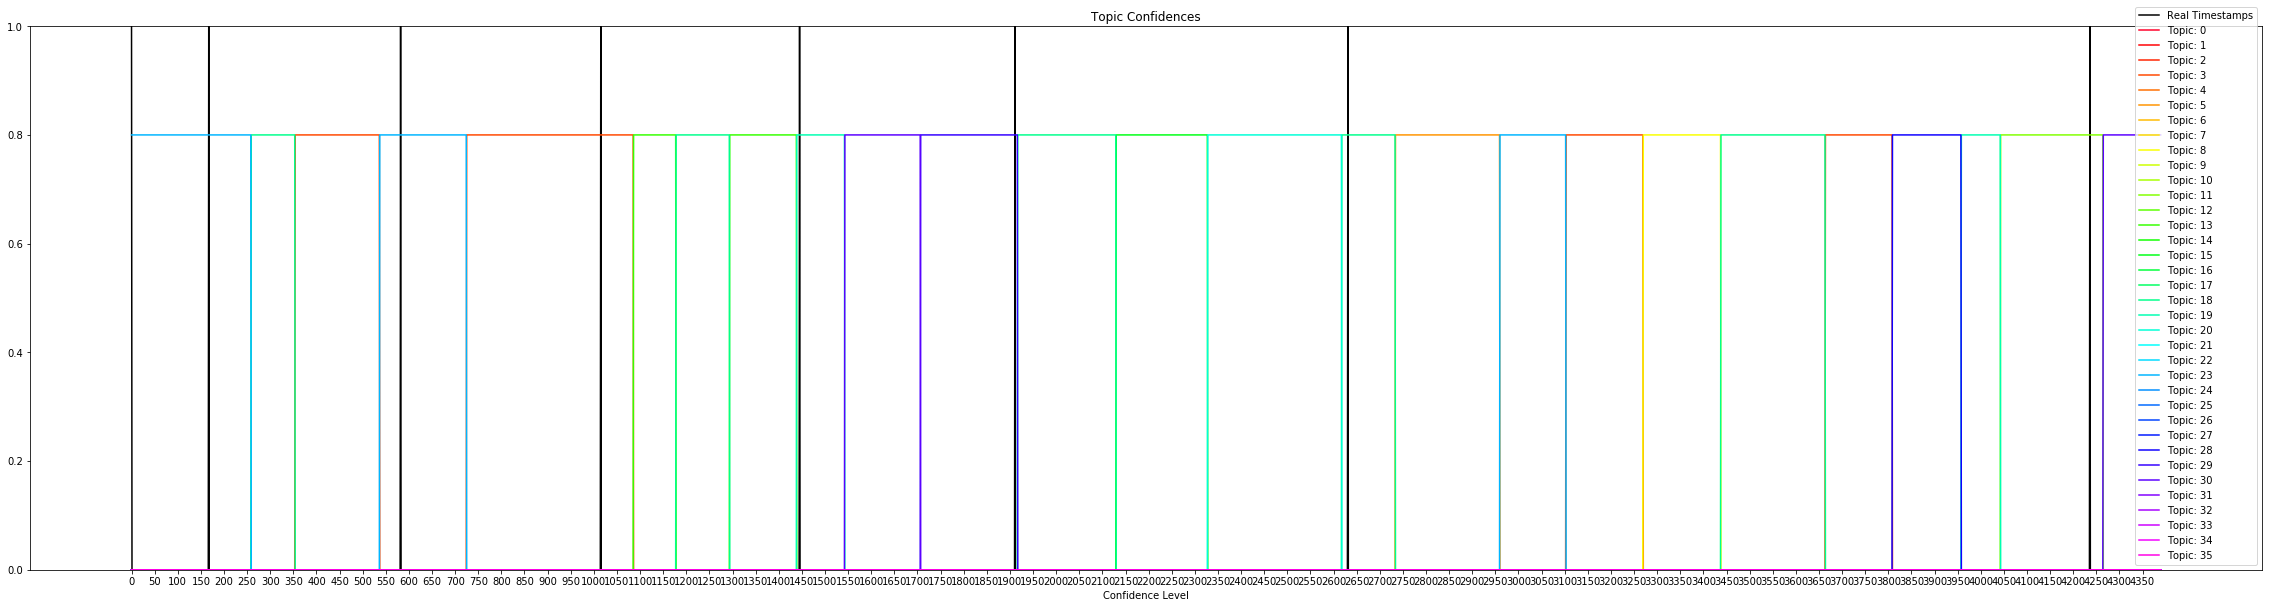

In [66]:
final_topic_confi = get_final_topic_confi(sents, algo_stamps) #new topic graph based on algo timestamps
top_confi = np.zeros([int(pod_word_count("black.txt")/topic_size), len(sents)])

NUM_COLORS = int(pod_word_count("black.txt")/topic_size)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.title("Topic Confidences")
plt.xlabel("Sentence Number")
plt.xticks(np.arange(0, len(sents), 50))
plt.xlabel("Confidence Level")
plt.ylim(0,1)

r1, r2 = 0, len(sents)
# r1, r2 = 150, 200
x = np.arange(0, len(sents))
plt.plot(x[r1:r2], convert_to_gra(actual_stamps, sents)[r1:r2], label="Real Timestamps", color="black") #graph original timestamps in black
# plt.plot(x[r1:r2], final_topic_confi[r1:r2], label="Model", color="dimgrey")



for ind, i in enumerate(final_topic_confi): #set graph
    top_confi[int(i)][ind] = .8
    
for i in range(int(pod_word_count("black.txt")/topic_size)): #graph the timestamps as according to algorithm, each color corresponds to a new topic
    plt.plot(x[r1:r2],top_confi[i][r1:r2], label="Topic: "+str(i))

plt.legend()
plt.rcParams['figure.figsize'] = [40, 10]
plt.show()